In [7]:
import os
import requests

pdf_path = "path-book.pdf"

if not os.path.exists(pdf_path):
  print(f"[INFO] File Doesnt Exist, Downloading....")

  url = 'https://pressbooks.oer.hawaii.edu/humannutrition2/'
  filename = pdf_path

  response = requests.get(url)

  if response.status_code == 200:
    with open(filename, "wb") as file:
          file.write(response.content)
    print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

else:
  print(f"File {pdf_path} exists.")

File path-book.pdf exists.


In [8]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  
        text = page.get_text()  
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

/Users/gautamgaurisaria/Desktop/Projects/rag-scratch-v2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
32it [00:00, 927.64it/s]


[{'page_number': -41,
  'page_char_count': 100,
  'page_word_count': 23,
  'page_sentence_count_raw': 1,
  'page_token_count': 25.0,
  'text': 'Skip to content [image] Toggle Menu Primary Navigation •  Home •  Read •  Sign in •  Search in book:'},
 {'page_number': -40,
  'page_char_count': 145,
  'page_word_count': 23,
  'page_sentence_count_raw': 2,
  'page_token_count': 36.25,
  'text': 'Search Want to create or adapt books like this? Learn more about how Pressbooks supports open publishing practices.  Book Title: Human Nutrition:'}]

In [9]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': -13,
  'page_char_count': 638,
  'page_word_count': 87,
  'page_sentence_count_raw': 2,
  'page_token_count': 159.5,
  'text': 'University of Hawai‘i at Mānoa Food Science and Human Nutrition Program Contributors Alan Titchenal; Skylar Hara; Noemi Arceo Caacbay; William Meinke-Lau; Ya-Yun Yang; Marie Kainoa Fialkowski Revilla; Jennifer Draper; Gemady Langfelder; Cheryl Gibby; Chynna Nicole Chun; and Allison Calabrese License [image] Human Nutrition: 2020 Edition Copyright © 2020 by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted. Primary Subject Dietetics and nutrition Publication Date August 26, 2020 Ebook ISBN 978-1-948027-08-3'},
 {'page_number': -38,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -29,
  'page_char_count': 907,
  'page_word_count': 

In [10]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,100,23,1,25.00,Skip to content [image] Toggle Menu Primary Na...
1,-40,145,23,2,36.25,Search Want to create or adapt books like this...
2,-39,574,93,3,143.50,2020 Edition Authors: University of Hawai‘i at...
3,-38,0,1,1,0.00,
4,-37,38,5,1,9.50,Creative Commons Attribution Read Book


In [11]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,32.00,32.00,32.00,32.00,32.00
mean,-25.50,618.81,93.91,7.09,154.70
std,9.38,371.78,56.18,4.62,92.94
min,-41.00,0.00,1.00,1.00,0.00
25%,-33.25,133.75,23.00,1.75,33.44
50%,-25.50,838.50,126.50,9.50,209.62
75%,-17.75,907.00,137.25,11.00,226.75
max,-10.00,961.00,150.00,13.00,240.25


In [12]:
from spacy.lang.en import English 

nlp = English()

nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2


list(doc.sents)

[This is a sentence., This another sentence.]

In [13]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|██████████| 32/32 [00:00<00:00, 1244.06it/s]


In [14]:
random.sample(pages_and_texts, k=1)

[{'page_number': -15,
  'page_char_count': 372,
  'page_word_count': 53,
  'page_sentence_count_raw': 2,
  'page_token_count': 93.0,
  'text': 'Book Information Authors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program License [image] Human Nutrition: 2020 Edition Copyright © 2020 by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted. Subject Dietetics and nutrition',
  'sentences': ['Book Information Authors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program License [image] Human Nutrition: 2020 Edition Copyright © 2020 by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
   'Subject Dietetics and nutrition'],
  'page_sentence_count_spacy': 2}]

In [15]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,32.00,32.00,32.00,32.00,32.00,32.00
mean,-25.50,618.81,93.91,7.09,154.70,7.03
std,9.38,371.78,56.18,4.62,92.94,4.60
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,-33.25,133.75,23.00,1.75,33.44,1.75
50%,-25.50,838.50,126.50,9.50,209.62,9.00
75%,-17.75,907.00,137.25,11.00,226.75,11.00
max,-10.00,961.00,150.00,13.00,240.25,13.00


In [16]:
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]



In [18]:
# Loop through pages and texts and split sentences into chunks
from tqdm import tqdm
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 32/32 [00:00<00:00, 50476.77it/s]


In [19]:
random.sample(pages_and_texts, k=1)

[{'page_number': -25,
  'page_char_count': 808,
  'page_word_count': 120,
  'page_sentence_count_raw': 11,
  'page_token_count': 202.0,
  'text': 'Human Nutrition Program and Human Nutrition Program 3. Water-Soluble Vitamins University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 4. Antioxidants University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 5. The Body’s Offense University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 6. Phytochemicals University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 13. X. Chapter 10. Major Minerals 1. Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 2. Calcium University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 3. Phosphorus',
  'sentences': ['Human Nutrition Program a

In [20]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,32.00,32.00,32.00,32.00,32.00,32.00,32.00
mean,-25.50,618.81,93.91,7.09,154.70,7.03,1.31
std,9.38,371.78,56.18,4.62,92.94,4.60,0.54
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,-33.25,133.75,23.00,1.75,33.44,1.75,1.00
50%,-25.50,838.50,126.50,9.50,209.62,9.00,1.00
75%,-17.75,907.00,137.25,11.00,226.75,11.00,2.00
max,-10.00,961.00,150.00,13.00,240.25,13.00,2.00


In [21]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 32/32 [00:00<00:00, 19562.41it/s]


42

In [22]:
random.sample(pages_and_chunks, k=1)

[{'page_number': -15,
  'sentence_chunk': 'Book Information Authors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program License [image] Human Nutrition: 2020 Edition Copyright © 2020 by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted. Subject Dietetics and nutrition',
  'chunk_char_count': 372,
  'chunk_word_count': 53,
  'chunk_token_count': 93.0}]

In [23]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,42.00,42.00,42.00,42.00
mean,-25.12,470.88,71.21,117.72
std,8.45,371.53,56.52,92.88
min,-41.00,21.00,3.00,5.25
25%,-31.75,83.25,12.50,20.81
50%,-25.50,603.50,87.50,150.88
75%,-18.25,821.00,125.50,205.25
max,-10.00,961.00,150.00,240.25


In [24]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 24.5 | Text: Powered by Pressbooks • Guides and Tutorials • |Pressbooks Directory [image] Pressbooks on YouTube
Chunk token count: 24.0 | Text: Skip to content [image] Toggle Menu Primary Navigation • Home • Read • Sign in • Search in book:
Chunk token count: 17.5 | Text: Proteins in a Nutshell University of Hawai‘i at Mānoa Food Science and
Chunk token count: 5.25 | Text: Pressbooks on Twitter
Chunk token count: 10.25 | Text: Digestion and Absorption of Carbohydrates


In [25]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -40,
  'sentence_chunk': 'Search Want to create or adapt books like this?Learn more about how Pressbooks supports open publishing practices. Book Title: Human Nutrition:',
  'chunk_char_count': 143,
  'chunk_word_count': 21,
  'chunk_token_count': 35.75},
 {'page_number': -39,
  'sentence_chunk': "2020 Edition Authors: University of Hawai‘i at Mānoa Food Science and Human Nutrition Program [image] Download this book • EPUB • Digital PDF • Print PDF • Pressbooks XML • OpenDocument Book Description: This textbook serves as an introduction to nutrition for undergraduate students and is the OER textbook for the FSHN 185 The Science of Human Nutrition course at the University of Hawai'i at Mānoa. The book covers basic concepts in human nutrition, key information about essential nutrients, basic nutritional assessment, and nutrition across the lifespan. License:",
  'chunk_char_count': 569,
  'chunk_word_count': 88,
  'chunk_token_count': 142.25}]

In [26]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07983702e-02  3.03164758e-02 -2.01217812e-02  6.86484948e-02
 -2.55256165e-02 -8.47691391e-03 -2.07267498e-04 -6.32378086e-02
  2.81606745e-02 -3.33354510e-02  3.02633327e-02  5.30721247e-02
 -5.03526963e-02  2.62288749e-02  3.33313718e-02 -4.51577678e-02
  3.63045447e-02 -1.37122255e-03 -1.20171178e-02  1.14947045e-02
  5.04511073e-02  4.70856801e-02  2.11913809e-02  5.14606461e-02
 -2.03746464e-02 -3.58889699e-02 -6.67787332e-04 -2.94394251e-02
  4.95859124e-02 -1.05639743e-02 -1.52013935e-02 -1.31758000e-03
  4.48197387e-02  1.56023540e-02  8.60379600e-07 -1.21390715e-03
 -2.37978864e-02 -9.09394759e-04  7.34493835e-03 -2.53932225e-03
  5.23370281e-02 -4.68043759e-02  1.66214444e-02  4.71579656e-02
 -4.15599085e-02  9.01930209e-04  3.60277891e-02  3.42214033e-02
  9.68227237e-02  5.94829582e-02 -1.64984688e-02 -3.51249352e-02
  5.92521019e-03 -7.07876345e-04 -2.4103

In [27]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
embedding_model.to("cpu")

# # Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
   item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 28/28 [00:04<00:00,  5.64it/s]

CPU times: user 3.62 s, sys: 673 ms, total: 4.29 s
Wall time: 5.01 s


In [28]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [29]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 4.85 s, sys: 1.08 s, total: 5.93 s
Wall time: 3.96 s


tensor([[ 0.0571,  0.0648,  0.0010,  ...,  0.0146, -0.0361, -0.0101],
        [ 0.0336,  0.0333, -0.0022,  ..., -0.0156, -0.0161,  0.0190],
        [ 0.0349,  0.0378, -0.0151,  ..., -0.0083,  0.0221,  0.0236],
        ...,
        [ 0.0253,  0.0736, -0.0055,  ..., -0.0243,  0.0173,  0.0223],
        [ 0.0380,  0.0522,  0.0054,  ..., -0.0087, -0.0126,  0.0063],
        [ 0.0349,  0.0518,  0.0069,  ..., -0.0206, -0.0239,  0.0020]])

In [30]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [31]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-40,Search Want to create or adapt books like this...,143,21,35.75,[ 5.70594370e-02 6.47962913e-02 1.00421673e-...
1,-39,2020 Edition Authors: University of Hawai‘i at...,569,88,142.25,[ 3.35613377e-02 3.33316438e-02 -2.22232030e-...
2,-35,1. Preface University of Hawai‘i at Mānoa Food...,884,135,221.00,[ 3.49126346e-02 3.77918594e-02 -1.51006440e-...
3,-34,University of Hawai‘i at Mānoa Food Science an...,912,139,228.00,[ 5.94860949e-02 1.37211513e-02 3.77675262e-...
4,-33,5. Central Nervous System University of Hawai‘...,866,133,216.50,[ 3.47766168e-02 -1.30114481e-02 1.52082536e-...


In [4]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([28, 768])

In [33]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-40,Search Want to create or adapt books like this...,143,21,35.75,"[0.057059437, 0.0647962913, 0.00100421673, -0...."
1,-39,2020 Edition Authors: University of Hawai‘i at...,569,88,142.25,"[0.0335613377, 0.0333316438, -0.0022223203, -0..."
2,-35,1. Preface University of Hawai‘i at Mānoa Food...,884,135,221.00,"[0.0349126346, 0.0377918594, -0.015100644, -0...."
3,-34,University of Hawai‘i at Mānoa Food Science an...,912,139,228.00,"[0.0594860949, 0.0137211513, 0.00377675262, -0..."
4,-33,5. Central Nervous System University of Hawai‘...,866,133,216.50,"[0.0347766168, -0.0130114481, 0.0152082536, -0..."


In [34]:
embeddings[0]

tensor([ 5.7059e-02,  6.4796e-02,  1.0042e-03, -2.8444e-02,  1.3829e-02,
         1.9869e-02,  2.3854e-02,  2.2963e-02,  4.5781e-02, -4.1696e-03,
         5.6242e-02,  1.1750e-02, -2.6128e-03,  6.8283e-02,  5.0318e-02,
        -2.8279e-02,  5.8691e-02,  5.6772e-02, -3.4386e-03,  1.0302e-02,
        -2.7244e-02,  2.9946e-02,  4.7031e-02,  6.3285e-04,  3.6035e-02,
         1.2508e-02,  2.2380e-03,  2.8022e-02, -7.2814e-04, -6.8987e-02,
        -1.4477e-02,  2.6718e-02,  1.5859e-03, -3.6077e-02,  1.9722e-06,
         2.1255e-02, -5.1127e-02,  3.2548e-02, -4.8196e-02,  4.5182e-02,
         8.5081e-02, -1.7657e-02, -1.6841e-02, -2.4173e-02,  3.1504e-02,
         6.4349e-03,  2.7314e-02,  5.8594e-02, -3.2552e-02, -2.2067e-02,
         8.2425e-03, -4.6135e-02,  1.1992e-02,  6.4160e-03, -3.1855e-03,
         4.5361e-02, -5.8770e-03,  3.1093e-02,  8.9699e-02,  4.4980e-03,
        -8.3060e-03,  5.6134e-02, -1.2688e-02,  1.5598e-02, -2.0064e-02,
         5.8738e-02,  1.4163e-02, -1.1566e-01,  2.0

In [5]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device)

In [10]:
query = "macronutrients functions"
print(f"Query: {query}")


query_embedding = embedding_model.encode(query, convert_to_tensor=True)


from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 28 embeddings: 0.00433 seconds.


torch.return_types.topk(
values=tensor([0.5214, 0.4885, 0.4545, 0.4512, 0.4412]),
indices=tensor([ 1,  7, 27, 26, 13]))

In [37]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([2800, 768])
Time take to get scores on 2800 embeddings: 0.00094 seconds.


In [14]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [39]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.5214
Text:
2020 Edition Authors: University of Hawai‘i at Mānoa Food Science and Human
Nutrition Program [image] Download this book • EPUB • Digital PDF • Print PDF •
Pressbooks XML • OpenDocument Book Description: This textbook serves as an
introduction to nutrition for undergraduate students and is the OER textbook for
the FSHN 185 The Science of Human Nutrition course at the University of Hawai'i
at Mānoa. The book covers basic concepts in human nutrition, key information
about essential nutrients, basic nutritional assessment, and nutrition across
the lifespan. License:
Page number: -39


Score: 0.4885
Text:
University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and
Human Nutrition Program 3. The Functions of Carbohydrates in the Body University
of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition
Program 4. Health Consequences and Benefits of High- Carbohydrate Diets
University of Haw

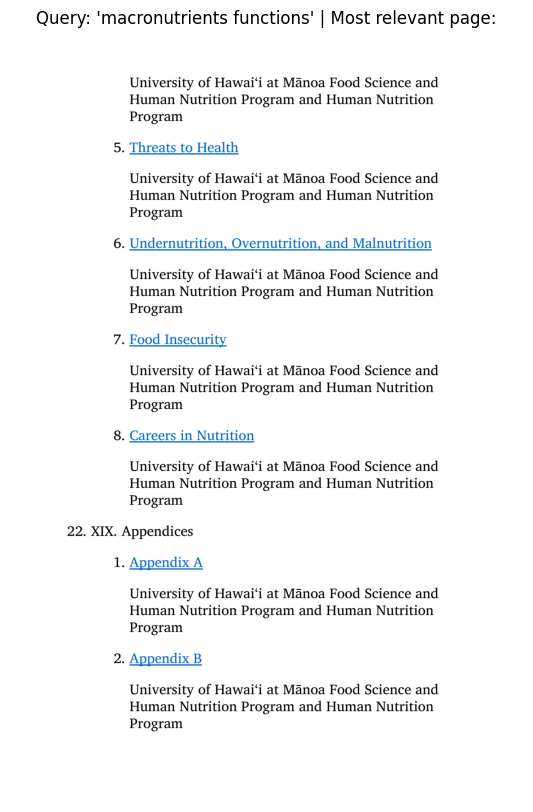

In [ ]:
import fitz

pdf_path = "path-book.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 20) 


img = page.get_pixmap(dpi=300)


doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [1]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [11]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices
def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [12]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 28 embeddings: 0.00009 seconds.


(tensor([0.1024, 0.0915, 0.0603, 0.0335, 0.0202]),
 tensor([13,  4,  3,  1, 17]))

In [15]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 28 embeddings: 0.00007 seconds.
Query: symptoms of pellagra

Results:
Score: 0.1024
Human Nutrition Program and Human Nutrition Program 3. Water-Soluble Vitamins
University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and
Human Nutrition Program 4. Antioxidants University of Hawai‘i at Mānoa Food
Science and Human Nutrition Program and Human Nutrition Program 5. The Body’s
Offense University of Hawai‘i at Mānoa Food Science and Human Nutrition Program
and Human Nutrition Program 6. Phytochemicals University of Hawai‘i at Mānoa
Food Science and Human Nutrition Program and Human Nutrition Program 13. X.
Chapter 10. Major Minerals 1. Introduction University of Hawai‘i at Mānoa Food
Science and Human Nutrition Program and Human Nutrition Program 2. Calcium
University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and
Human Nutrition Program 3. Phosphorus
Page number: -25


Score: 0.0915
5. Central Nervous System University of

AttributeError: module 'torch.cpu' has no attribute 'get_device_properties'